# 키워드 분석

## 분류 정의

### 네일 쉐입 키워드 정의

In [101]:
shape_keywords = {
    "round": [
        "round", "라운드", "둥근", "동그란", "동글동글", "라운드네일"
    ],
    "oval": [
        "oval", "오벌", "오발", "타원", "타원형", "달걀형", "오벌네일", "오벌형"
    ],
    "square": [
        "square", "스퀘어", "네모", "직각", "각진", "스퀘어네일", "네모네일"
    ],
    "almond": [
        "almond", "아몬드", "아몬드쉐입", "아몬드형"
    ],
    "squoval": [
        "squoval", "스퀘어오벌", "스퀘어 오벌", "스쿠오벌"
    ],
}

### 네일 디자인 분류 정의

In [102]:
design_keywords = {
    "solid":      ["단색", "심플", "베이직", "solid"],
    "gradient":   ["그라데이션", "옴브레", "gradient", "ombre"],
    "french":     ["프렌치", "프렌치네일", "french"],
    "half_moon":  ["반달", "하프문", "half moon"],
    "line":       ["라인", "라인네일", "선", "line"],
    "dot":        ["도트", "땡땡이", "dot"],
    "marble":     ["마블", "marble"],
    "sticker":    ["스티커", "데코", "파츠", "sticker", "deco", "parts"],
    "chrome":     ["크롬", "미러", "chrome", "mirror"],
    "jelly":      ["젤리", "젤리네일", "jelly"],
    "velvet":     ["벨벳", "파우더", "무광파우더", "velvet", "powder"],
    "glitter":    ["글리터", "반짝이", "글리터네일", "glitter"],
}

## CSV 로드

In [60]:
## CSV 로드

import pandas as pd

base = pd.read_csv("basic_data/20251120_01_multi.csv")
shape = pd.read_csv("basic_data/20251120_02_multi.csv")
feature = pd.read_csv("basic_data/20251120_03_multi.csv")

base["group"] = "base"
shape["group"] = "shape"
feature["group"] = "feature"

df = pd.concat([base, shape, feature], ignore_index=True)

# full_text 가 있다고 가정
df["full_text"] = df["full_text"].fillna("")

## 함수

### 역매핑

In [103]:
import re
'''
역매핑 : 유사 키워드 -> 한 키워드로 대응
'''

# --- 쉐입 키워드 역매핑 ---

def make_boundary_pattern(term: str) -> re.Pattern:
    """
    한/영 공통 '단어 경계' 기반 매칭 패턴 생성
    - 앞 문자([가-힣A-Za-z0-9])가 아니어야 함
    - 뒤 문자
    - 예: '오벌'은 단독일 때만 매칭, '스퀘어오벌' 내부에선 매칭 X
    """
    escaped = re.escape(term)
    pattern = rf"(?<![A-Za-z0-9가-힣]){escaped}(?![A-Za-z0-9])"
    return re.compile(pattern)

# shape → (variant, pattern) 리스트로 전처리
shape_matchers = []  # [(shape_name, variant, compiled_pattern), ...]

for shape_name, variants in shape_keywords.items():
    # (선택) 길이 긴 것부터 정렬해두면 더 안전
    for v in sorted(variants, key=len, reverse=True):
        shape_matchers.append((shape_name, v, make_boundary_pattern(v)))

def get_shapes_in_text(text: str):
    if not isinstance(text, str):
        return set()
    found = set()
    for shape_name, variant, pat in shape_matchers:
        if pat.search(text):
            found.add(shape_name)
    return found


# --- 디자인 키워드 역매핑 ---

variant_to_design = {}
for design_name, variants in design_keywords.items():
    for v in variants:
        variant_to_design[v] = design_name


### 문장 분리 + context 추출

In [104]:
### Full_text 문장 단위 split

def split_sentences(text):
    if not isinstance(text, str):
        return []
    return [s.strip() for s in re.split(r'[.!?…\n]', text) if s.strip()]

### 쉐입 단어가 포함된 문장 + 주변 문장 추출

def extract_shape_context(text, window=1):
    sents = split_sentences(text)
    out = []

    for i, sent in enumerate(sents):
        # 문장 안에 쉐입(variant)이 하나라도 있으면 context 대상
        if any(pat.search(sent) for (_, _, pat) in shape_matchers):
            start = max(0, i - window)
            end   = min(len(sents), i + window + 1)
            out.append(" ".join(sents[start:end]))

    return out

### df에 shape_contexts 컬럼 생성
df["shape_contexts"] = df["full_text"].apply(extract_shape_context)

### 노이즈 제거 (전처리)

In [105]:
import re
from collections import Counter

def tokenize(text):
    # 한글/영문 단어 단위 토큰화
    return re.findall(r"[가-힣A-Za-z]+", text)

word_counter = Counter()

for contexts in df["shape_contexts"]:
    for ctx in contexts:
        tokens = tokenize(ctx)
        word_counter.update(tokens)

# 등장 빈도 상위 50개 출력
for w, c in word_counter.most_common(50):
    print(f"{w:20} {c}")


스퀘어                  385
라운드                  309
네일                   305
손톱                   277
오벌                   259
쉐입                   254
아몬드                  189
수                    135
오벌네일                 121
더                    104
디자인                  99
잘                    94
둥근                   92
쉐입은                  91
있습니다                 85
네일아트                 75
핑거수트                 75
네모네일                 75
스퀘어네일                72
네일팁                  70
짧은                   68
손톱이                  61
부드러운                 60
인상을                  57
발레리나                 57
젤네일                  57
더욱                   55
모양                   55
코핀                   53
어떤                   53
쉐입으로                 51
네일은                  51
각진                   50
스텔라뷰티                50
네일샵                  49
너무                   47
라운드네일                47
가지                   47
어울리는                 46
디자인을                 46
네일추천                 46
데일리네일 

In [106]:
noise_words = [
    # "네일", "손톱", "아트", "샵", "고객", "예쁜", "예쁘다",
    # "사용", "오늘", "사진", "분위기", "기본", "컬러",
    # "모양", "길이", "추천", "예요", "합니다", "해요",
    "발레리나", "복대동네일", "스텔라뷰티"
]

def remove_noise(text, noise_list):
    for nw in noise_list:
        # 단어 경계 매칭으로 잘라냄
        pattern = rf"(?<![가-힣a-zA-Z0-9]){re.escape(nw)}(?![가-힣a-zA-Z0-9])"
        text = re.sub(pattern, " ", text)
    return text

### 쉐입 단어가 포함된 문장 + 주변 문장 추출

In [107]:
### 디자인 키워드도 dict → flatten 형태로 변환

flat_design_keywords = [
    w for words in design_keywords.values() for w in words
]

In [108]:
from collections import Counter

shape_design_count = Counter()

for contexts in df["shape_contexts"]:
    for ctx in contexts:
        shapes = get_shapes_in_text(ctx)

        # design 분석 전 노이즈 제거
        clean_ctx = remove_noise(ctx, noise_words)

        designs = {
            variant_to_design[w]
            for w in variant_to_design.keys()
            if w in ctx
        }

        for s in shapes:
            for d in designs:
                shape_design_count[(s, d)] += 1

In [109]:
shape_design_count.most_common(30)

[(('square', 'line'), 95),
 (('oval', 'line'), 82),
 (('round', 'line'), 80),
 (('square', 'french'), 50),
 (('almond', 'line'), 34),
 (('square', 'gradient'), 30),
 (('oval', 'glitter'), 28),
 (('oval', 'gradient'), 26),
 (('oval', 'sticker'), 18),
 (('square', 'glitter'), 17),
 (('almond', 'glitter'), 17),
 (('almond', 'sticker'), 16),
 (('oval', 'marble'), 16),
 (('almond', 'gradient'), 15),
 (('round', 'french'), 15),
 (('almond', 'marble'), 14),
 (('square', 'sticker'), 14),
 (('round', 'gradient'), 13),
 (('oval', 'solid'), 11),
 (('round', 'glitter'), 9),
 (('square', 'marble'), 8),
 (('oval', 'french'), 8),
 (('square', 'chrome'), 8),
 (('square', 'solid'), 7),
 (('squoval', 'line'), 6),
 (('almond', 'french'), 4),
 (('round', 'sticker'), 3),
 (('round', 'jelly'), 3),
 (('round', 'solid'), 2),
 (('round', 'dot'), 2)]

### 누락 키워드 확인

In [110]:
## 쉐입, 디자인 누락 키워드 확인

# shape 전체 variant 단어 집합
shape_terms = set()
for vlist in shape_keywords.values():
    for v in vlist:
        shape_terms.add(v)

# design 전체 variant 단어 집합
design_terms = set()
for vlist in design_keywords.values():
    for v in vlist:
        design_terms.add(v)

# noise 단어 집합
noise_terms = set(noise_words)

for w, c in word_counter.most_common(100):
    tags = []
    if w in shape_terms:
        tags.append("shape")
    if w in design_terms:
        tags.append("design")
    if w in noise_terms:
        tags.append("noise")

    tag_str = ",".join(tags) if tags else "-"

    print(f"{w:15s} {c:5d}   [{tag_str}]")


스퀘어               385   [shape]
라운드               309   [shape]
네일                305   [-]
손톱                277   [-]
오벌                259   [shape]
쉐입                254   [-]
아몬드               189   [shape]
수                 135   [-]
오벌네일              121   [shape]
더                 104   [-]
디자인                99   [-]
잘                  94   [-]
둥근                 92   [shape]
쉐입은                91   [-]
있습니다               85   [-]
네일아트               75   [-]
핑거수트               75   [-]
네모네일               75   [shape]
스퀘어네일              72   [shape]
네일팁                70   [-]
짧은                 68   [-]
손톱이                61   [-]
부드러운               60   [-]
인상을                57   [-]
발레리나               57   [noise]
젤네일                57   [-]
더욱                 55   [-]
모양                 55   [-]
코핀                 53   [-]
어떤                 53   [-]
쉐입으로               51   [-]
네일은                51   [-]
각진                 50   [shape]
스텔라뷰티              50   [noise]
네일샵 

## 분석

### import

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트
font_path = 'basic_data/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'

### Count

In [120]:
N = 100 # 상위

rows = [
    {"shape": s, "design": d, "count": c}
    for (s, d), c in shape_design_count.items()
]
df_sd_all = pd.DataFrame(rows)

df_sd_all.sort_values("count", ascending=False).head(N)

,shape,design,count
4,square,line,95
10,oval,line,82
3,round,line,80
2,square,french,50
0,almond,line,34
8,square,gradient,30
9,oval,glitter,28
11,oval,gradient,26
18,oval,sticker,18
13,almond,glitter,17


### Heatmap

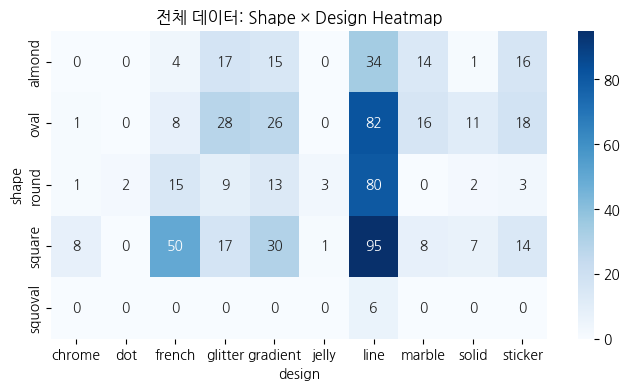

In [125]:
K = 100  # 상위
top_designs = (
    df_sd_all.groupby("design")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(K)
    .index
)

df_sd_top = df_sd_all[df_sd_all["design"].isin(top_designs)]

pivot_all = df_sd_top.pivot(index="shape", columns="design", values="count").fillna(0)

plt.figure(figsize=(8, 4))
sns.heatmap(pivot_all, annot=True, fmt=".0f", cmap="Blues")
plt.title("전체 데이터: Shape × Design Heatmap")
plt.show()


In [ ]:
### 비율

In [126]:
ratio_all = pivot_all.div(pivot_all.sum(axis=1), axis=0).fillna(0)
ratio_all

design,chrome,dot,french,glitter,gradient,jelly,line,marble,solid,sticker
shape,,,,,,,,,,
almond,0.000000,0.000000,0.039604,0.168317,0.148515,0.000000,0.336634,0.138614,0.009901,0.158416
oval,0.005263,0.000000,0.042105,0.147368,0.136842,0.000000,0.431579,0.084211,0.057895,0.094737
round,0.007812,0.015625,0.117188,0.070312,0.101562,0.023438,0.625000,0.000000,0.015625,0.023438
square,0.034783,0.000000,0.217391,0.073913,0.130435,0.004348,0.413043,0.034783,0.030435,0.060870
squoval,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


### 퍼센트(%)

In [127]:
ratio_all_pct = (ratio_all * 100).round(1)
ratio_all_pct


design,chrome,dot,french,glitter,gradient,jelly,line,marble,solid,sticker
shape,,,,,,,,,,
almond,0.0,0.0,4.0,16.8,14.9,0.0,33.7,13.9,1.0,15.8
oval,0.5,0.0,4.2,14.7,13.7,0.0,43.2,8.4,5.8,9.5
round,0.8,1.6,11.7,7.0,10.2,2.3,62.5,0.0,1.6,2.3
square,3.5,0.0,21.7,7.4,13.0,0.4,41.3,3.5,3.0,6.1
squoval,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0


In [ ]:
## 텍스트

In [128]:
for shape in ratio_all_pct.index:
    sub = ratio_all_pct.loc[shape]
    sub_sorted = sub.sort_values(ascending=False)
    print(f"\n=== {shape} 추천 디자인 (%) ===")
    for design, pct in sub_sorted.items():
        print(f"  {design:15s} : {pct:4.1f}%")



=== almond 추천 디자인 (%) ===
  line            : 33.7%
  glitter         : 16.8%
  sticker         : 15.8%
  gradient        : 14.9%
  marble          : 13.9%
  french          :  4.0%
  solid           :  1.0%
  chrome          :  0.0%
  dot             :  0.0%
  jelly           :  0.0%

=== oval 추천 디자인 (%) ===
  line            : 43.2%
  glitter         : 14.7%
  gradient        : 13.7%
  sticker         :  9.5%
  marble          :  8.4%
  solid           :  5.8%
  french          :  4.2%
  chrome          :  0.5%
  dot             :  0.0%
  jelly           :  0.0%

=== round 추천 디자인 (%) ===
  line            : 62.5%
  french          : 11.7%
  gradient        : 10.2%
  glitter         :  7.0%
  jelly           :  2.3%
  sticker         :  2.3%
  solid           :  1.6%
  dot             :  1.6%
  chrome          :  0.8%
  marble          :  0.0%

=== square 추천 디자인 (%) ===
  line            : 41.3%
  french          : 21.7%
  gradient        : 13.0%
  glitter         :  7.4%
  sticker  